### Forward diffusion of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch,torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


In [2]:
def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch
def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np
print ("Ready.")

Ready.


### Plot configuration

In [3]:
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5);
print ("Ready")

Ready


### Training data

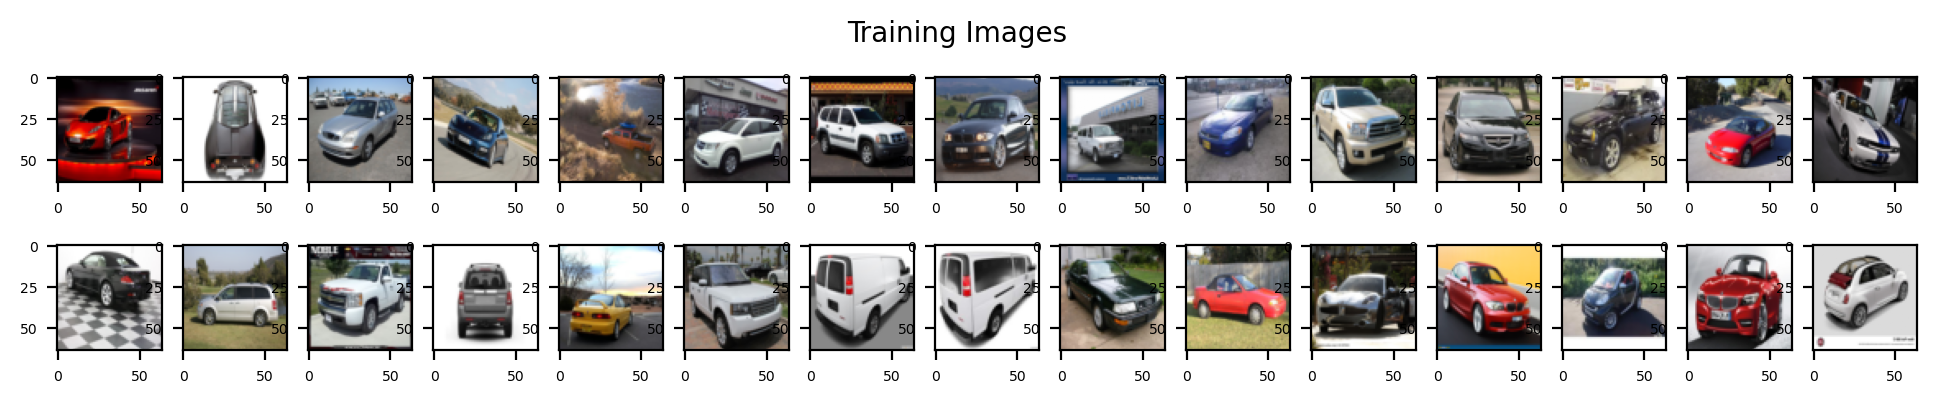

Ready.


In [4]:
trs = [transforms.Resize((64,64)),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor()] # [B x C x H x W]
dataset = torchvision.datasets.StanfordCars(
    root='../data',split='train',transform=transforms.Compose(trs),download=True)
dataloader = DataLoader(dataset=dataset,batch_size=128,shuffle=True,drop_last=True)
n_plot,n_row = 30,2
plt.figure(figsize=(12,2));
for i_idx,img_idx in enumerate(np.random.permutation(len(dataset))[:n_plot]):
    plt.subplot(n_row,n_plot//n_row,i_idx+1)
    plt.imshow(torch2np(dataset[img_idx][0]).transpose([1,2,0]))
plt.suptitle('Training Images',fontsize=10); plt.show()
print ("Ready.")

### DDPM 
`Forward` diffusion process: 
$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$

`Jump` diffusion process: 
$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$ where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

`Reverse` process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Default DDPM Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=1,000$ 

Here, we modified $\beta_1$ to be $0.001$ and $\beta_T$ to be $0.01$.

In [5]:
# Precompute some constants for DDPM
dc = {}
dc['T'] = 500
dc['betas'] = torch.linspace(start=0.001,end=0.01,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")

Ready.


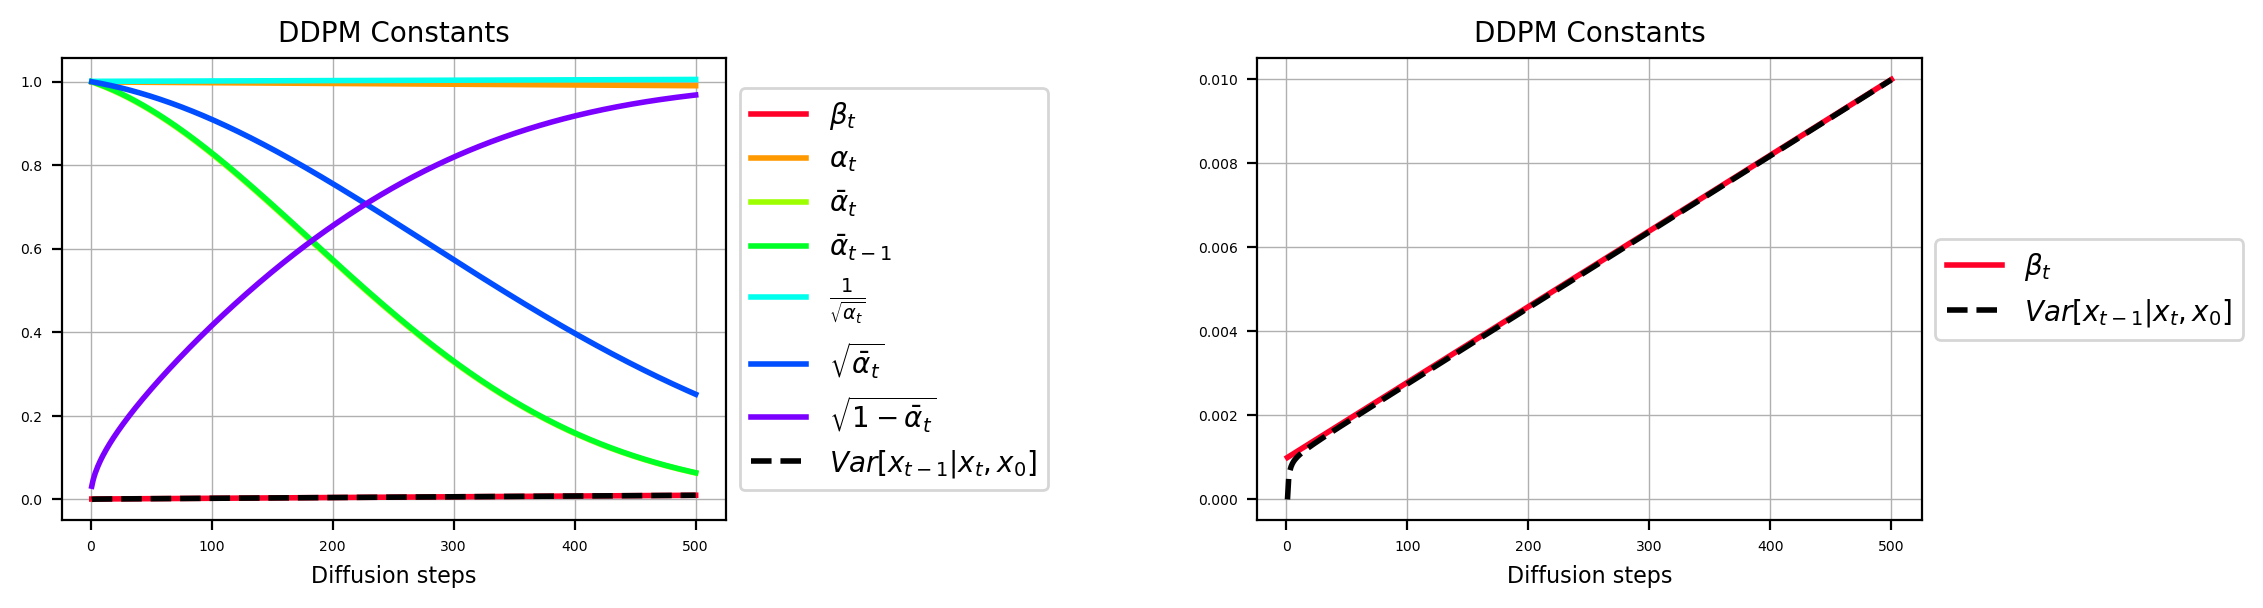

In [6]:
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.8); plt.show()

### Helper function

In [7]:
def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
print ("Ready.")

Ready.


### Forward diffusion sampling for Images

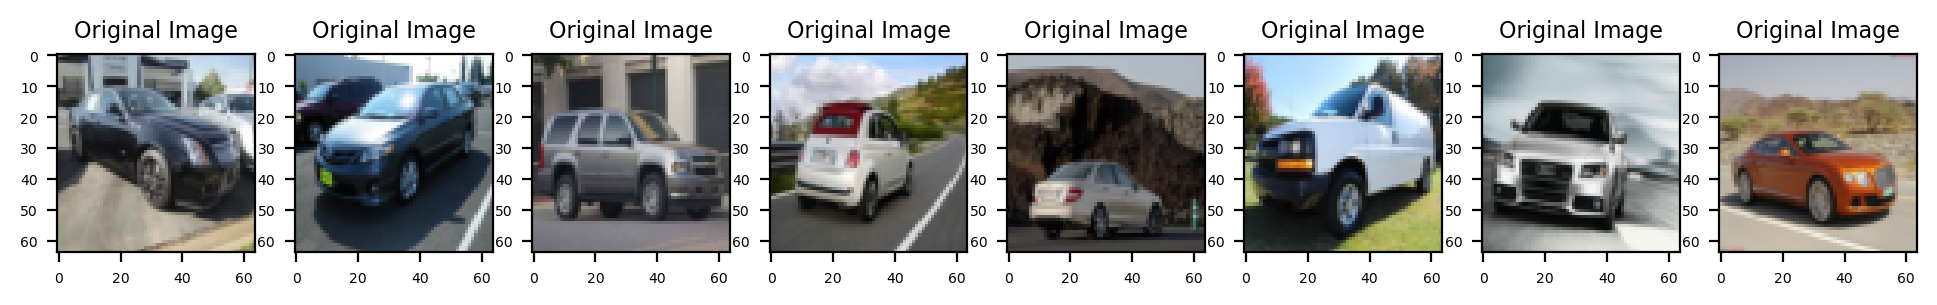

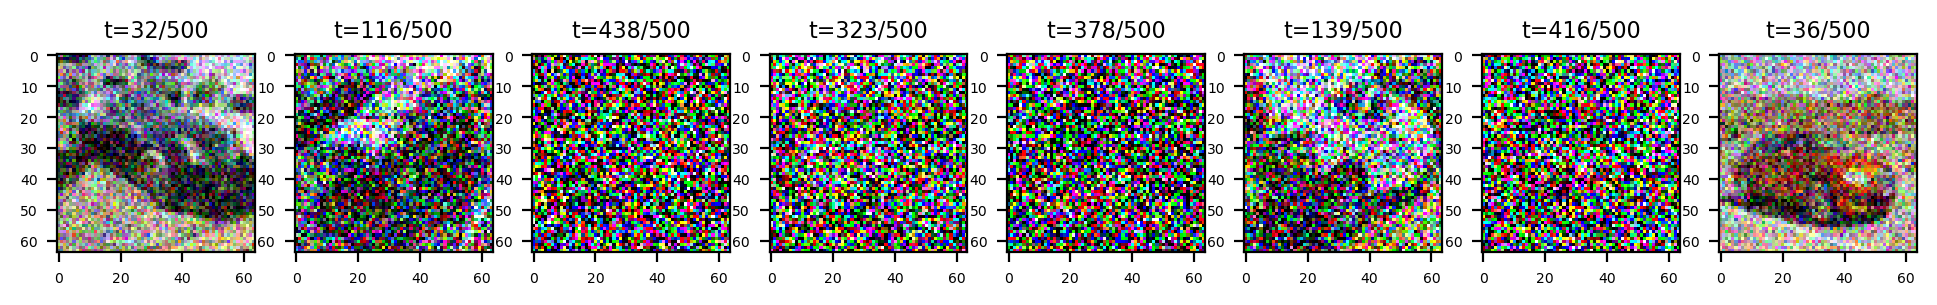

Ready.


In [8]:
x_0 = next(iter(dataloader))[0] # [128 x 3 x 64 x 64]
steps = torch.randint(low=0,high=dc['T'],size=(128,)) # [128]
sqrt_alphas_bar_t = gather_and_reshape(
    values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [128 x 1 x 1 x 1]
sqrt_one_minus_alphas_bar_t = gather_and_reshape(
    values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [128 x 1 x 1 x 1]
x_t_mean = sqrt_alphas_bar_t * x_0 # [128 x 3 x 64 x 64]
x_t_std = sqrt_one_minus_alphas_bar_t # [128 x 3 x 64 x 64]
noise = torch.randn_like(input=x_0) # [128 x 3 x 64 x 64]
x_t = x_t_mean + x_t_std*noise # [128 x 3 x 64 x 64]
x_t = x_t.clip(min=0.0,max=1.0) # clip values between 0.0 to 1.0
# Plot
n_img = 8
plt.figure(figsize=(12,1.5))
for img_idx in range(n_img):
    plt.subplot(1,n_img,img_idx+1)
    plt.imshow(torch2np(x_0[img_idx]).transpose([1,2,0]))
    plt.title('Original Image',fontsize=8)
plt.show()
plt.figure(figsize=(12,1.5))
for img_idx in range(n_img):
    plt.subplot(1,n_img,img_idx+1)
    plt.imshow(torch2np(x_t[img_idx]).transpose([1,2,0]))
    plt.title('t=%d/%d'%(torch2np(steps[img_idx]),dc['T']),fontsize=8)
plt.show()
print ("Ready.")

`Forward` diffusion process: 

$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$

$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$ where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

### Forward diffusion batch sampling 

In [9]:
def forward_diffusion_sample(x_0,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x C x H x W]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape)
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape)
    x_t_mean = sqrt_alphas_bar_t * x_0
    x_t_std = sqrt_one_minus_alphas_bar_t
    noise = torch.randn_like(input=x_0)
    x_t = x_t_mean + noise_rate*x_t_std*noise
    return x_t,noise
print ("Ready.")

Ready.


### Ancestral sampling `at once` by first tiling a single image then do batch sampling

noise_rate:[1.0]


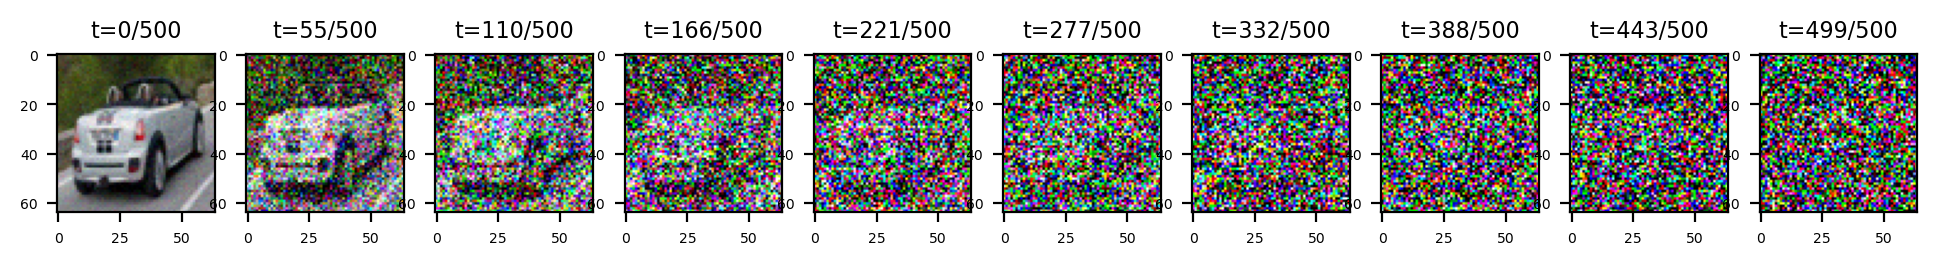

noise_rate:[0.5]


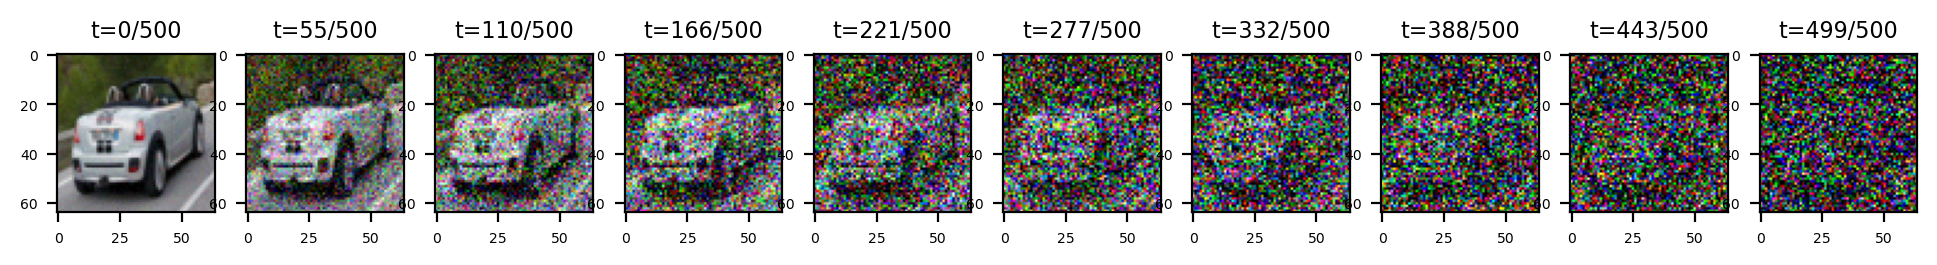

noise_rate:[0.0]


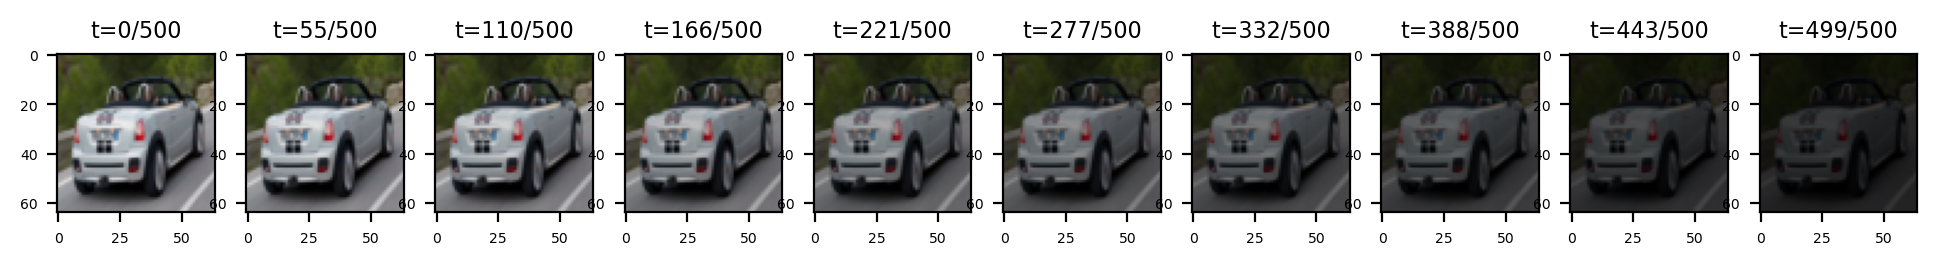

In [10]:
n_step = 10
x_0_tile = torch.tile(input=next(iter(dataloader))[0][0],dims=(n_step,1,1,1))
steps = torch.linspace(start=0,end=dc['T']-1,steps=n_step).type(torch.LongTensor)
for noise_rate in [1.0,0.5,0.0]:
    print ("noise_rate:[%.1f]"%(noise_rate))
    x_t_tile,_ = forward_diffusion_sample(x_0=x_0_tile,steps=steps,dc=dc,noise_rate=noise_rate)
    # Plot 
    plt.figure(figsize=(12,2))
    for img_idx in range(n_step):
        plt.subplot(1,n_step,img_idx+1)
        plt.imshow(torch2np(x_t_tile[img_idx]).transpose([1,2,0]).clip(0.0,1.0))
        plt.title('t=%d/%d'%(torch2np(steps[img_idx]),dc['T']),fontsize=8)
    plt.show()